In [1]:
import torch.nn as nn
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from ssl_methods.data_modules import LinearEvaluationDataModule, ReconstructionDataModule

In [2]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [3]:
reconstruction_data_module = ReconstructionDataModule( "../data", preprocess)
reconstruction_data_module.setup()

In [4]:
reconstruction_data_module.train_dataloader()

In [5]:
linear_data_module = LinearEvaluationDataModule("../data", preprocess)
linear_data_module.setup()

In [6]:
dataset = linear_data_module.train_dataset

In [7]:
samples = []
for sample in dataset:
    samples.append(sample)

samples = samples[:16]

In [8]:
idx_to_label = [
    "airplane",
    "bird",
    "car",
    "cat",
    "deer",
    "dog",
    "horse",
    "monkey",
    "ship",
    "truck"]

In [9]:
idx_to_label = [
    "samolot",  # airplane
    "ptak",     # bird
    "samochód", # car
    "kot",      # cat
    "jeleń",    # deer
    "pies",     # dog
    "koń",      # horse
    "małpa",    # monkey
    "statek",   # ship
    "ciężarówka" # truck
]


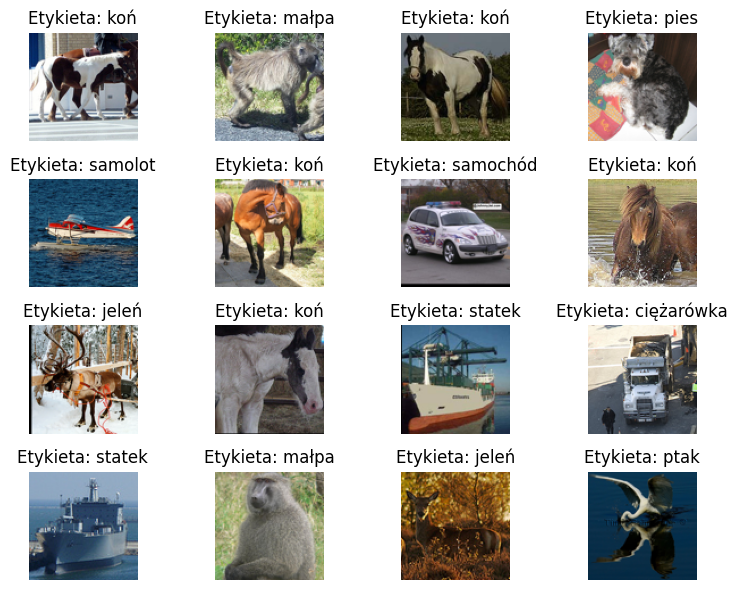

In [10]:
import torch
import matplotlib.pyplot as plt

# Assuming 'data_list' is your list of tuples with (image_tensor, label)
data_list = samples  # your list of 16 (image, label) tuples

# Number of images you want per row in your grid
images_per_row = 4

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(nrows=len(data_list) // images_per_row, ncols=images_per_row, figsize=(8, 6))
axes = axes.flatten()  # Flatten the array of axes if it's multidimensional

for idx, (img_tensor, label) in enumerate(data_list):
    ax = axes[idx]
    # Convert the image tensor to numpy array and make sure its shape is (H, W, C)
    img = img_tensor.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(f'Etykieta: {idx_to_label[label]}')

# Adjust subplot parameters to reduce space between images
plt.subplots_adjust(wspace=0.0, hspace=0.0)  # Adjust these values as needed for your layout

plt.tight_layout()
plt.show()


In [48]:
import pandas as pd

In [49]:
acc_path = "../experiments/val_acc"
loss_path = "../experiments/val_loss"

In [50]:
flow = "lightning_logs_latent-flow-linear.csv"
flow_l = "lightning_logs_latent-flow-large-linear-2.csv"

In [51]:
flow_linear_acc = pd.read_csv(f"{acc_path}/{flow}")
flow_l_linear_acc = pd.read_csv(f"{acc_path}/{flow_l}")

In [52]:
flow_linear_loss = pd.read_csv(f"{loss_path}/{flow}")
flow_l_linear_loss = pd.read_csv(f"{loss_path}/{flow_l}")

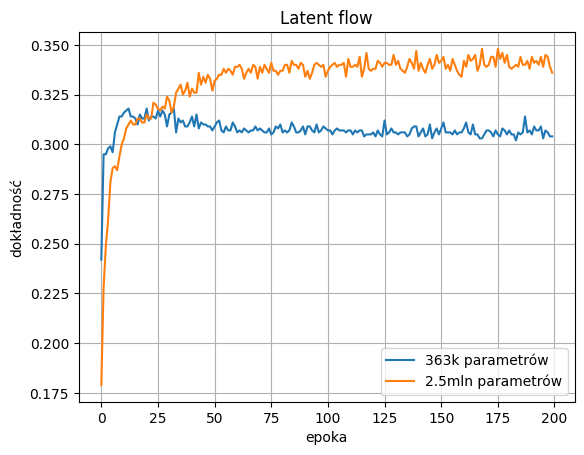

In [63]:
plt.plot(flow_linear_acc["Value"], label="363k parametrów")
plt.plot(flow_l_linear_acc["Value"], label="2.5mln parametrów")
plt.title("Latent flow")
plt.grid()
plt.legend()
plt.xlabel("epoka")
plt.ylabel("dokładność")
plt.show()

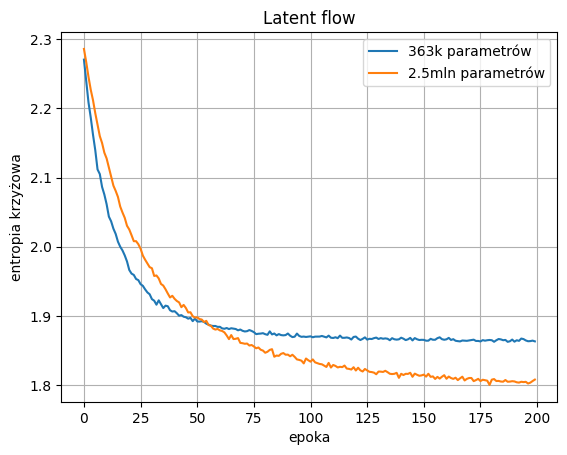

In [64]:
plt.plot(flow_linear_loss["Value"], label="363k parametrów")
plt.plot(flow_l_linear_loss["Value"], label="2.5mln parametrów")
plt.title("Latent flow")
plt.grid()
plt.legend()
plt.xlabel("epoka")
plt.ylabel("entropia krzyżowa")
plt.show()

In [55]:
flow_s = pd.read_csv("../experiments/lightning_logs_latent-flow-linear.csv")
flow_l = pd.read_csv("../experiments/val_acc/lightning_logs_latent-flow-large-linear-2.csv")

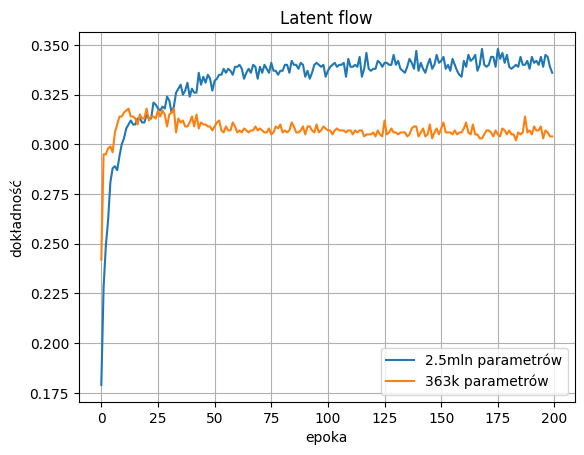

In [56]:
# plt.plot(ae_linear_acc["Value"], label="autokoder")
# plt.plot(flow_linear_acc["Value"], label="flow")
plt.plot(flow_l["Value"], label="2.5mln parametrów")
plt.plot(flow_s["Value"], label="363k parametrów")
plt.title("Latent flow")
plt.grid()
plt.legend()
plt.xlabel("epoka")
plt.ylabel("dokładność")
plt.show()

In [57]:
from ssl_methods.latent_flow.flow import FlowNet
flow = FlowNet(nz=64, hidden_size=512, nblocks=8)

In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [65]:
flow_s = pd.read_csv("../experiments/lightning_logs_latent-flow-pretraining.csv")
flow_l = pd.read_csv("../experiments/lightning_logs_latent-flow-large-pretraining-2.csv")

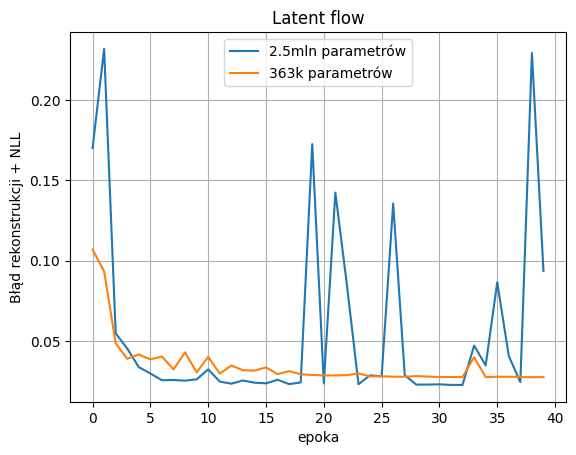

In [68]:
# plt.plot(ae_linear_acc["Value"], label="autokoder")
# plt.plot(flow_linear_acc["Value"], label="flow")
plt.plot(flow_l["Value"][:40], label="2.5mln parametrów")
plt.plot(flow_s["Value"][:40], label="363k parametrów")
plt.title("Latent flow")
plt.grid()
plt.legend()
plt.xlabel("epoka")
plt.ylabel("Błąd rekonstrukcji + NLL")
plt.show()

In [69]:
from torchvision import models

In [70]:


class ResNet18Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(ResNet18Encoder, self).__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(resnet.fc.in_features, latent_dim)
        self.fc_var = nn.Linear(resnet.fc.in_features, latent_dim)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var


class ResNet18Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(ResNet18Decoder, self).__init__()
        self.decoder_input = nn.Linear(latent_dim, 512 * 3 * 3)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                512, 256, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                32, 3, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder_input(x)
        x = x.view(-1, 512, 3, 3)
        x = self.decoder(x)
        return x
